# Трансформер с нуля

В этом notebook будет реализована архитектура трансформера из статьи *Attention Is All You Need*.

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl

from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from tokenizers import (
    Tokenizer,
    normalizers,
    pre_tokenizers,
    models,
    processors,
    trainers,
)
from torchmetrics.classification import MulticlassAccuracy
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TQDMProgressBar,
)
from tqdm import tqdm
from pathlib import Path
from contextlib import contextmanager
from typing import Literal

/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Архитектура Transformer

### Multi-Head Self-Attention

In [2]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, bias=True):
        """
        Простая реализация multi-head self-attention.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, (
            "embed_dim must be divisible by num_heads"
        )

        # Матрицы W^Q, W^K, W^V
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=bias)

        # Выходная проекция
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        padding_mask: torch.Tensor | None = None,
        attention_mask: torch.Tensor | None = None,
    ):
        """
        Args:
            query, key, value: (batch_size, seq_len, embed_dim)
            padding_mask: (batch_size, seq_len) — True для токенов, которые нужно замаскировать
            attention_mask: (seq_len, seq_len) — causal mask (True = запрещено смотреть)
        """
        B, Q_len, _ = query.shape
        K_len = key.size(1)

        # 1. Объединяем Q, K, V и применяем линейное преобразование
        q = self.W_q(query)
        k = self.W_k(key)
        v = self.W_v(value)

        # 2. Разделяем на головы: (B, num_heads, seq_len, head_dim)
        def reshape_heads(x: torch.Tensor) -> torch.Tensor:
            # x: (B, seq_len, embed_dim)
            # return: (B, num_heads, seq_len, head_dim)
            return x.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        q, k, v = map(reshape_heads, (q, k, v))

        # 3. Считаем attention: QK^T / sqrt(d_k)
        # scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim**0.5)

        # 4. Добавляем маски
        # Casual attention_mask
        if attention_mask is not None:
            # attention_mask: (seq_len, seq_len)
            # True = нельзя смотреть, добавляем -inf
            scores = scores.masked_fill(
                attention_mask[None, None, :, :].bool(), float("-inf")
            )

        # Применяем padding_mask (если есть)
        if padding_mask is not None:
            # padding_mask: (B, seq_len)
            scores = scores.masked_fill(
                padding_mask[:, None, None, :].bool(), float("-inf")
            )

        # 5. Применяем Softmax
        attn = F.softmax(scores, dim=-1)

        # 6. Взвешенные значения
        out = torch.matmul(attn, v)

        # 7. Объединение голов
        # out: (B, num_heads, Q_len, head_dim)
        out = out.transpose(1, 2).contiguous().view(B, Q_len, self.embed_dim)

        # 8. Пропускаем через линейный слой
        out = self.out(out)

        return out


### Feed-Forward Neural Network

In [3]:
class FeedForwardNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()  # или GELU для более современных моделей

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Encoder block

In [4]:
class EncoderBlock(nn.Module):
    """Post-Normalization.
    x -> MHA -> + Residual -> LayerNorm
    -> FFN -> + Residual -> LayerNorm
    """

    def __init__(self, embed_dim, num_heads, ff_hidden_dim, dropout=0.1):
        super().__init__()
        self.mhsa = MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForwardNN(embed_dim, ff_hidden_dim, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask=None, attention_mask=None):
        """
        Args:
            x: (batch_size, seq_len, embed_dim)
            padding_mask: (batch_size, seq_len) — True для токенов, которые нужно замаскировать
            attention_mask: (seq_len, seq_len) — causal mask (True = запрещено смотреть)
        """
        attn_out = self.mhsa(x, x, x, padding_mask, attention_mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        ffn_out = self.ffn(x)
        x = x + self.dropout(ffn_out)
        x = self.norm2(x)

        return x

### Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len=512,
        num_blocks=6,
        embed_dim=512,
        num_heads=8,
        ff_hidden_dim=2048,
        dropout=0.1,
    ):
        super().__init__()
        # === 1. Token Embeddings ===
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        # === 2. Positional Embeddings ===
        self.pos_embedding = nn.Embedding(max_seq_len, embed_dim)

        # === 3. Dropout после эмбеддингов ===
        self.dropout = nn.Dropout(dropout)

        # === 4. Стеки энкодерных блоков ===
        self.layers = nn.ModuleList(
            [
                EncoderBlock(embed_dim, num_heads, ff_hidden_dim, dropout)
                for _ in range(num_blocks)
            ]
        )

    def forward(self, input_ids, padding_mask=None, attention_mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            padding_mask: (batch_size, seq_len) — True для паддингов
            attention_mask: (seq_len, seq_len) — causal mask
        """

        B, seq_len = input_ids.shape

        # === 1. Эмбеддинги токенов ===
        token_emb = self.token_embedding(input_ids)  # (B, seq_len, embed_dim)

        # === 2. Позиционные эмбеддинги ===
        positions = torch.arange(seq_len, device=input_ids.device)
        pos_emb = self.pos_embedding(positions)[None, :, :]
        # (1, seq_len, embed_dim)

        # === 3. Суммируем и применяем dropout ===
        x = token_emb + pos_emb
        x = self.dropout(x)

        # === 4. Пропускаем через энкодерные блоки ===
        for layer in self.layers:
            x = layer(x, padding_mask, attention_mask)

        return x

### Decoder Block

In [6]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        embed_dim=512,
        num_heads=8,
        ff_hidden_dim=2048,
        dropout=0.1,
    ):
        super().__init__()
        # Masked Multi-Head Self-Attention
        self.mhsa = MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        # Multi-Head Cross-Attention
        self.mhca = MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForwardNN(embed_dim, ff_hidden_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x,
        encoder_output,
        decoder_padding_mask=None,
        encoder_padding_mask=None,
        attention_mask=None,
    ):
        self_attn = self.mhsa(
            query=x,
            key=x,
            value=x,
            padding_mask=decoder_padding_mask,
            attention_mask=attention_mask,
        )
        x = x + self.dropout(self_attn)
        x = self.norm1(x)

        cross_attn = self.mhca(
            query=x,
            key=encoder_output,
            value=encoder_output,
            padding_mask=encoder_padding_mask,
        )
        x = x + self.dropout(cross_attn)
        x = self.norm2(x)

        fnn_out = self.ffn(x)
        x = x + self.dropout(fnn_out)
        x = self.norm3(x)

        return x

### Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len=512,
        num_blocks=6,
        embed_dim=512,
        num_heads=8,
        ff_hidden_dim=2048,
        dropout=0.1,
    ):
        super().__init__()
        # === 1. Token Embeddings ===
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        # === 2. Positional Embeddings ===
        self.pos_embedding = nn.Embedding(max_seq_len, embed_dim)

        # === 3. Dropout после эмбеддингов ===
        self.dropout = nn.Dropout(dropout)

        # === 4. Стеки энкодерных блоков ===
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, num_heads, ff_hidden_dim, dropout)
                for _ in range(num_blocks)
            ]
        )
        self.out = nn.Linear(embed_dim, vocab_size)

    def forward(
        self,
        input_ids,
        encoder_outputs=None,
        decoder_padding_mask=None,
        encoder_padding_mask=None,
        attention_mask=None,
    ):
        """
        Args:
            input_ids: (batch_size, seq_len)
            padding_mask: (batch_size, seq_len) — True для паддингов
            attention_mask: (seq_len, seq_len) — causal mask
        """

        B, seq_len = input_ids.shape

        # === 1. Эмбеддинги токенов ===
        token_emb = self.token_embedding(input_ids)  # (B, seq_len, embed_dim)

        # === 2. Позиционные эмбеддинги ===
        positions = torch.arange(seq_len, device=input_ids.device)
        pos_emb = self.pos_embedding(positions)[None, :, :]
        # (1, seq_len, embed_dim)

        # === 3. Суммируем и применяем dropout ===
        x = token_emb + pos_emb
        x = self.dropout(x)

        # === 4. Пропускаем через энкодерные блоки ===
        for layer in self.layers:
            x = layer(
                x,
                encoder_outputs,
                decoder_padding_mask=decoder_padding_mask,
                encoder_padding_mask=encoder_padding_mask,
                attention_mask=attention_mask,
            )

        logits = self.out(x)
        return logits

### Transformer

In [8]:
class Transformer(nn.Module):
    def __init__(
        self,
        encoder_vocab_size,
        decoder_vocab_size,
        padding_idx=0,
        max_seq_len=512,
        num_blocks=6,
        embed_dim=512,
        num_heads=8,
        ff_hidden_dim=2048,
        dropout=0.1,
    ):
        super().__init__()

        self.padding_idx = padding_idx

        self.encoder = Encoder(
            encoder_vocab_size,
            max_seq_len,
            num_blocks,
            embed_dim,
            num_heads,
            ff_hidden_dim,
            dropout,
        )

        self.decoder = Decoder(
            decoder_vocab_size,
            max_seq_len,
            num_blocks,
            embed_dim,
            num_heads,
            ff_hidden_dim,
            dropout,
        )

    def _make_padding_mask(self, x: torch.Tensor) -> torch.Tensor:
        return (x == self.padding_idx).to(x.device)

    def _make_attention_mask(self, y: torch.Tensor) -> torch.Tensor:
        # y: (batch_size, seq_len)
        return torch.triu(
            torch.ones((y.size(1), y.size(1)), device=y.device), diagonal=1
        )

    def forward(self, x, y):
        # x, y: (batch_size, seq_len)

        encoder_padding_mask = self._make_padding_mask(x)
        decoder_padding_mask = self._make_padding_mask(y)
        attention_mask = self._make_attention_mask(y)

        # encoder_outputs: (batch_size, seq_len, embed_dim)
        encoder_outputs = self.encoder(x, padding_mask=encoder_padding_mask)

        # decoder_outputs: (batch_size, seq_len, decoder_vocab_size)
        decoder_outputs = self.decoder(
            y,
            encoder_outputs,
            decoder_padding_mask=decoder_padding_mask,
            encoder_padding_mask=encoder_padding_mask,
            attention_mask=attention_mask,
        )

        return decoder_outputs

## Датасет

Будем использовать тот же датасет, что и в [08.Machine-Translation.LSTM-Seq2Seq-Attention.ipynb](08.Machine-Translation.LSTM-Seq2Seq-Attention.ipynb).

Ниже скачивание `rus_eng.txt` файла с google drive. Каждая строка - это пара `русское_предложение[SEP]предложение_на_английском`. Сами предложения взяты из [tatoeba.org](https://tatoeba.org/en/downloads). Получение выборки можно посмотреть [здесь](08*.Preprocess.ipynb)

In [9]:
!gdown -c "https://drive.google.com/uc?id=10y6di8hDNzLvmvrHRj2iCo5GxFSxbGLH"

Skipping already downloaded file rus_eng.txt


In [10]:
with open("rus_eng.txt", "r", encoding="utf-8") as file:
    pairs = [line.strip() for line in file]

In [11]:
pairs[:3]

['Как патетично![SEP]How pathetic!',
 "Теперь ты мужчина.[SEP]You're a man now.",
 'Том повторил то, что он только что сказал.[SEP]Tom repeated what he had just said.']

In [12]:
len(pairs)

100000

## Train-Validation-Test Split

In [13]:
# Сначала разделяем на train и временный (val+test)
train_pairs, temp_pairs = train_test_split(
    pairs, test_size=0.3, random_state=42
)

# Затем временный разделяем на val и test
val_pairs, test_pairs = train_test_split(
    temp_pairs, test_size=0.5, random_state=42
)

In [14]:
print(f"train_size: {len(train_pairs)}")
print(f"val_size: {len(val_pairs)}")
print(f"test_size: {len(test_pairs)}")

train_size: 70000
val_size: 15000
test_size: 15000


## Токенизация

- Разделим на `input` и `target`, используя разделитель `[SEQ]`;
- Начало предложения пометим `[BOS]`, а конец - `[EOS]`;
- Обучим `bpe` токенизатор;

UPD.:
- Обучим `word-level` токенизатор, так как датасет маленький, из-за чего модель не может уловить все зависимости. Word-Level показал себя лучше.

In [15]:
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]

In [16]:
def separate(pair: str, separator: str = "[SEP]") -> list[str, str]:
    return pair.split(separator)


train_rus_sentences, train_eng_sentences = zip(
    *(separate(pair) for pair in train_pairs)
)
val_rus_sentences, val_eng_sentences = zip(
    *(separate(pair) for pair in val_pairs)
)
test_rus_sentences, test_eng_sentences = zip(
    *(separate(pair) for pair in test_pairs)
)

In [17]:
def create_bpe_tokenizer(lang: Literal["eng", "rus"]):
    tokenizer = Tokenizer(model=models.BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    if lang == "eng":
        tokenizer.normalizer = normalizers.Sequence(
            [
                normalizers.NFD(),
                normalizers.StripAccents(),
                normalizers.Lowercase(),
            ]
        )
    elif lang == "rus":
        tokenizer.normalizer = normalizers.Sequence([normalizers.Lowercase()])
    else:
        raise Exception(f"Unknown language '{lang}'")

    return tokenizer


def create_world_level_tokenizer(lang: Literal["eng", "rus"]):
    if lang == "eng":
        normalizers_lst = [
            normalizers.NFD(),
            normalizers.StripAccents(),
            normalizers.Lowercase(),
        ]
    elif lang == "rus":
        normalizers_lst = [
            normalizers.NFD(),
            normalizers.Lowercase(),
        ]
    else:
        raise Exception(f"Unknown language '{lang}'")

    tokenizer = Tokenizer(model=models.WordLevel(unk_token="[UNK]"))
    tokenizer.normalizer = normalizers.Sequence(normalizers_lst)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    return tokenizer


@contextmanager
def disable_tokenizer_parallelism():
    original_value = os.environ.get("TOKENIZERS_PARALLELISM")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    try:
        yield
    finally:
        if original_value is not None:
            os.environ["TOKENIZERS_PARALLELISM"] = original_value
        else:
            os.environ.pop("TOKENIZERS_PARALLELISM", None)

In [18]:
rus_tokenizer = create_world_level_tokenizer(lang="rus")
eng_tokenizer = create_world_level_tokenizer(lang="eng")

In [19]:
# VOCAB_SIZE = 16000
# rus_tokenizer_trainer = trainers.BpeTrainer(
#     vocab_size=VOCAB_SIZE, show_progress=True, special_tokens=SPECIAL_TOKENS
# )
# eng_tokenizer_trainer = trainers.BpeTrainer(
#     vocab_size=VOCAB_SIZE, show_progress=True, special_tokens=SPECIAL_TOKENS
# )

In [20]:
rus_tokenizer_trainer = trainers.WordLevelTrainer(
    special_tokens=SPECIAL_TOKENS
)
eng_tokenizer_trainer = trainers.WordLevelTrainer(
    special_tokens=SPECIAL_TOKENS
)

In [21]:
rus_tokenizer.train_from_iterator(train_rus_sentences, rus_tokenizer_trainer)

In [22]:
eng_tokenizer.train_from_iterator(train_eng_sentences, eng_tokenizer_trainer)

## Dataset-ы и DataLoader-ы

In [23]:
class TranslationDataset(data.Dataset):
    def __init__(
        self,
        rus_sentences: list[str],
        eng_sentences: list[str],
        rus_tokenizer: Tokenizer,
        eng_tokenizer: Tokenizer,
    ):
        super().__init__()
        self.rus_tokenizer = rus_tokenizer
        self.eng_tokenizer = eng_tokenizer

        self.encoder_inputs = [
            torch.tensor(sentence.ids, dtype=torch.long)
            for sentence in rus_tokenizer.encode_batch(rus_sentences)
        ]

        decoder_temp = [
            sentence.ids
            for sentence in eng_tokenizer.encode_batch(eng_sentences)
        ]
        # Убираем [EOS]
        self.decoder_inputs = [
            torch.tensor(sentence[:-1], dtype=torch.long)
            for sentence in decoder_temp
        ]
        # Убираем [BOS]
        self.decoder_targets = [
            torch.tensor(sentence[1:], dtype=torch.long)
            for sentence in decoder_temp
        ]

        self.size = len(self.encoder_inputs)

    def __getitem__(
        self, index
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: encoder_inputs, decoder_inputs, decoder_targets
        """
        return (
            self.encoder_inputs[index],
            self.decoder_inputs[index],
            self.decoder_targets[index],
        )

    def __len__(self):
        return self.size

In [24]:
class DataCollator:
    def __init__(self, padding_idx: int = 0):
        self.padding_idx = padding_idx

    def __call__(self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        """
        Returns:
            tuple[torch.Tensor]: encoder_inputs_padded, encoder_inputs_lengths, decoder_inputs_padded, decoder_inputs_lengths, decoder_targets_padded,
        """
        encoder_inputs, decoder_inputs, decoder_targets = zip(*batch)

        encoder_inputs_padded = pad_sequence(
            encoder_inputs,
            batch_first=True,
            padding_value=self.padding_idx,
            padding_side="right",
        )
        decoder_inputs_padded = pad_sequence(
            decoder_inputs,
            batch_first=True,
            padding_value=self.padding_idx,
            padding_side="right",
        )
        decoder_targets_padded = pad_sequence(
            decoder_targets,
            batch_first=True,
            padding_value=self.padding_idx,
            padding_side="right",
        )

        return (
            encoder_inputs_padded,
            decoder_inputs_padded,
            decoder_targets_padded,
        )

In [25]:
BATCH_SIZE = 124

collator = DataCollator(padding_idx=rus_tokenizer.token_to_id("[PAD]"))

train_dataset = TranslationDataset(
    train_rus_sentences, train_eng_sentences, rus_tokenizer, eng_tokenizer
)
val_dataset = TranslationDataset(
    val_rus_sentences, val_eng_sentences, rus_tokenizer, eng_tokenizer
)
test_dataset = TranslationDataset(
    test_rus_sentences, test_eng_sentences, rus_tokenizer, eng_tokenizer
)

train_dataloader = data.DataLoader(
    train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collator, num_workers=2
)
val_dataloader = data.DataLoader(
    val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collator, num_workers=2
)
test_dataloader = data.DataLoader(
    test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collator, num_workers=2
)

## Обучение модели

In [26]:
class PLTransformer(pl.LightningModule):
    def __init__(
        self,
        encoder_vocab_size,
        decoder_vocab_size,
        padding_idx=0,
        max_seq_len=512,
        num_blocks=6,
        embed_dim=512,
        num_heads=8,
        ff_hidden_dim=2048,
        dropout=0.1,
        lr=1.0,
        logs_dir=Path("09.Transformer"),
    ):
        super().__init__()
        self.lr = lr
        self.logs_dir = logs_dir
        self.save_hyperparameters()
        self.model = Transformer(
            encoder_vocab_size,
            decoder_vocab_size,
            padding_idx,
            max_seq_len,
            num_blocks,
            embed_dim,
            num_heads,
            ff_hidden_dim,
            dropout,
        )
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = MulticlassAccuracy(
            decoder_vocab_size, average="micro"
        )
        self.val_accuracy = MulticlassAccuracy(
            decoder_vocab_size, average="micro"
        )
        self.test_accuracy = MulticlassAccuracy(
            decoder_vocab_size, average="micro"
        )

    def forward(self, batch):
        encoder_inputs, decoder_inputs, decoder_targets = batch
        logits = self.model(encoder_inputs, decoder_inputs)
        return logits, decoder_targets

    def _step(self, batch, stage: Literal["train", "val", "test"]):
        # logits: (batch_size, seq_len, vocab_size)
        logits, targets = self.forward(batch)
        loss = self.criterion(logits.transpose(1, 2), targets)
        self.log(
            f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss, logits, targets

    def training_step(self, batch):
        loss, logits, targets = self._step(batch, "train")
        predicts = torch.argmax(logits, dim=-1)
        acc = self.val_accuracy(predicts, targets)
        self.log(
            f"train_acc", acc, prog_bar=True, on_epoch=True, on_step=False
        )
        if self.global_step % 1000 == 0:
            lr = self.trainer.optimizers[0].param_groups[0]["lr"]
            self.log("lr", lr, prog_bar=True)
        return loss

    def validation_step(self, batch):
        # logits: (batch_size, seq_len, vocab_size)
        # targets: (batch_size, seq_len)
        loss, logits, targets = self._step(batch, "val")
        # predicts: (batch_size, seq_len)
        predicts = torch.argmax(logits, dim=-1)
        acc = self.val_accuracy(predicts, targets)
        self.log(f"val_acc", acc, prog_bar=True, on_epoch=True, on_step=False)

    def test_step(self, batch):
        # logits: (batch_size, seq_len, vocab_size)
        # targets: (batch_size, seq_len)
        loss, logits, targets = self._step(batch, "test")
        # predicts: (batch_size, seq_len)
        predicts = torch.argmax(logits, dim=-1)
        acc = self.test_accuracy(predicts, targets)
        self.log(f"test_acc", acc, prog_bar=True, on_epoch=True, on_step=False)

    def _get_warmup_scheduler(self, optimizer, d_model, warmup_steps=4000):
        def lr_lambda(step):
            step = max(1, step)
            return (d_model**-0.5) * min(
                step**-0.5, step * (warmup_steps**-1.5)
            )

        return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=self.lr
        )
        scheduler = self._get_warmup_scheduler(
            optimizer,
            d_model=self.model.encoder.token_embedding.embedding_dim,
            warmup_steps=4000,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # обновлять каждый шаг
                "frequency": 1,
            },
        }

    def configure_callbacks(self):
        return [
            EarlyStopping(monitor="val_loss", patience=3, mode="min"),
            ModelCheckpoint(
                monitor="val_loss",
                dirpath=self.logs_dir / "checkpoints",
                filename="best-model-{epoch:02d}-{val_loss:.2f}",
                save_top_k=1,
                mode="min",
            ),
            TQDMProgressBar(leave=True),
        ]

In [27]:
lit_model = PLTransformer(
    rus_tokenizer.get_vocab_size(),
    eng_tokenizer.get_vocab_size(),
    num_blocks=6,
    embed_dim=512,
    num_heads=8,
    ff_hidden_dim=2048,
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=CSVLogger(save_dir=lit_model.logs_dir),
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
# запуск
ckpt_path = lit_model.logs_dir / "checkpoints"
if ckpt_path.exists():
    ckpt_path = next(ckpt_path.iterdir())
    lit_model = PLTransformer.load_from_checkpoint(ckpt_path)
else:
    with disable_tokenizer_parallelism():
        trainer.fit(lit_model, train_dataloader, val_dataloader)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint, TQDMProgressBar
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | Transformer        | 73.0 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 16: 100%|██████████| 565/565 [00:36<00:00, 15.55it/s, v_num=0, lr=0.000466, val_loss=0.618, val_acc=0.901, train_loss=0.211, train_acc=0.948]


In [29]:
# запуск
ckpt_path = lit_model.logs_dir / "checkpoints"
if ckpt_path.exists():
    ckpt_path = next(ckpt_path.iterdir())
    lit_model = PLTransformer.load_from_checkpoint(ckpt_path)

In [31]:
results = pd.read_csv(
    lit_model.logs_dir / "lightning_logs/version_0/metrics.csv"
)

In [32]:
train_val_metrics = (
    results[["epoch", "train_acc", "train_loss", "val_acc", "val_loss"]]
    .groupby("epoch")
    .last()
    .reset_index()
)
train_val_metrics

,epoch,train_acc,train_loss,val_acc,val_loss
0,0,0.709426,2.405009,0.778463,1.441608
1,1,0.810984,1.185725,0.829514,1.042569
2,2,0.846030,0.910207,0.854837,0.863872
3,3,0.870372,0.731287,0.871040,0.754980
4,4,0.883999,0.625208,0.878893,0.699183
5,5,0.891221,0.563282,0.880936,0.685107
6,6,0.892075,0.544427,0.882027,0.677999
7,7,0.895006,0.518910,0.884676,0.660484
8,8,0.902326,0.469216,0.887767,0.639803
9,9,0.909688,0.420391,0.890618,0.619379


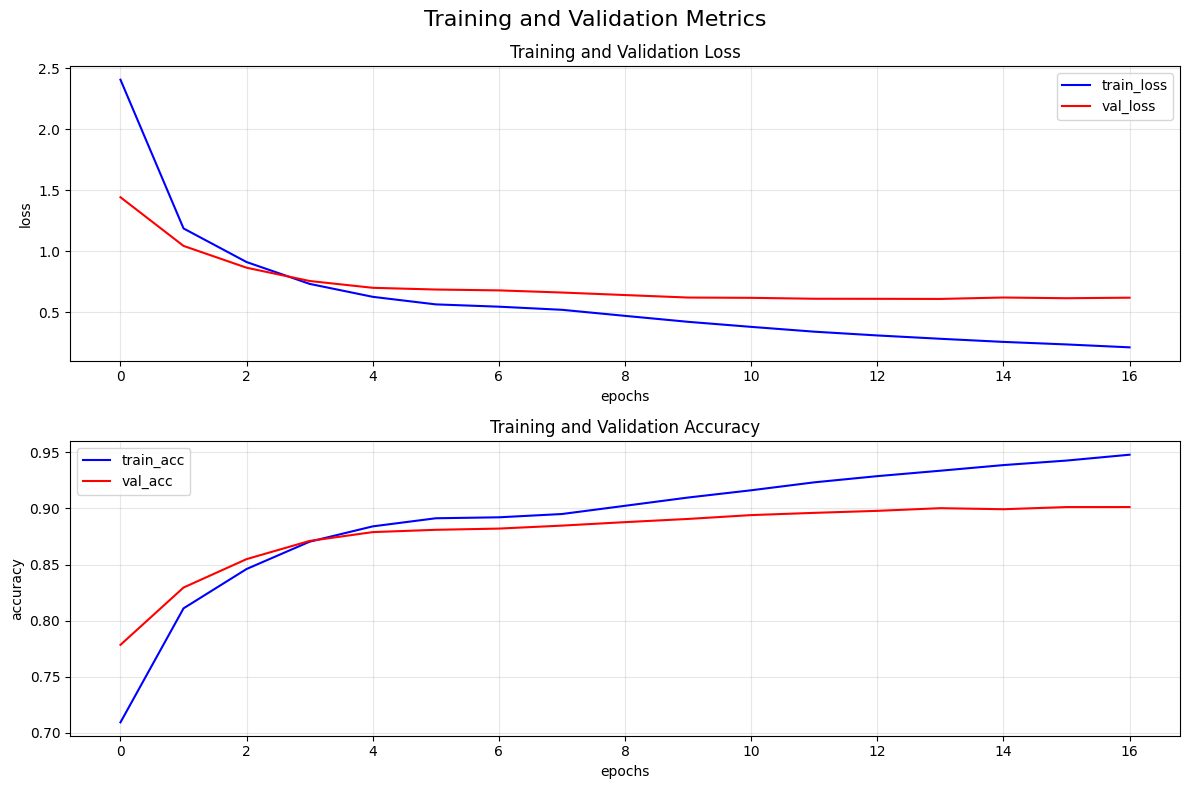

In [33]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["train_loss"],
    color="blue",
    label="train_loss",
)
ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_loss"],
    color="red",
    label="val_loss",
)
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()
ax1.set_title("Training and Validation Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(
    train_val_metrics["epoch"],
    train_val_metrics["train_acc"],
    color="blue",
    label="train_acc",
)

ax2.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_acc"],
    color="red",
    label="val_acc",
)

ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.legend()
ax2.set_title("Training and Validation Accuracy")
ax2.grid(True, alpha=0.3)

fig.suptitle("Training and Validation Metrics", fontsize=16)
fig.tight_layout()


In [34]:
lr_by_steps = (
    results[["step", "epoch", "lr"]]
    .dropna()
    .groupby("lr")
    .last()
    .reset_index()
    .sort_values("step")[["epoch", "step", "lr"]]
)
lr_by_steps

,epoch,step,lr
0,0,549,1.746928e-07
1,1,1099,1.746928e-04
2,3,2249,3.493856e-04
4,5,3349,5.240784e-04
8,7,4499,6.987713e-04
7,8,5049,6.250000e-04
6,10,6199,5.705443e-04
5,12,7299,5.282214e-04
3,14,8449,4.941059e-04


/tmp/ipykernel_13618/1073319320.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks())


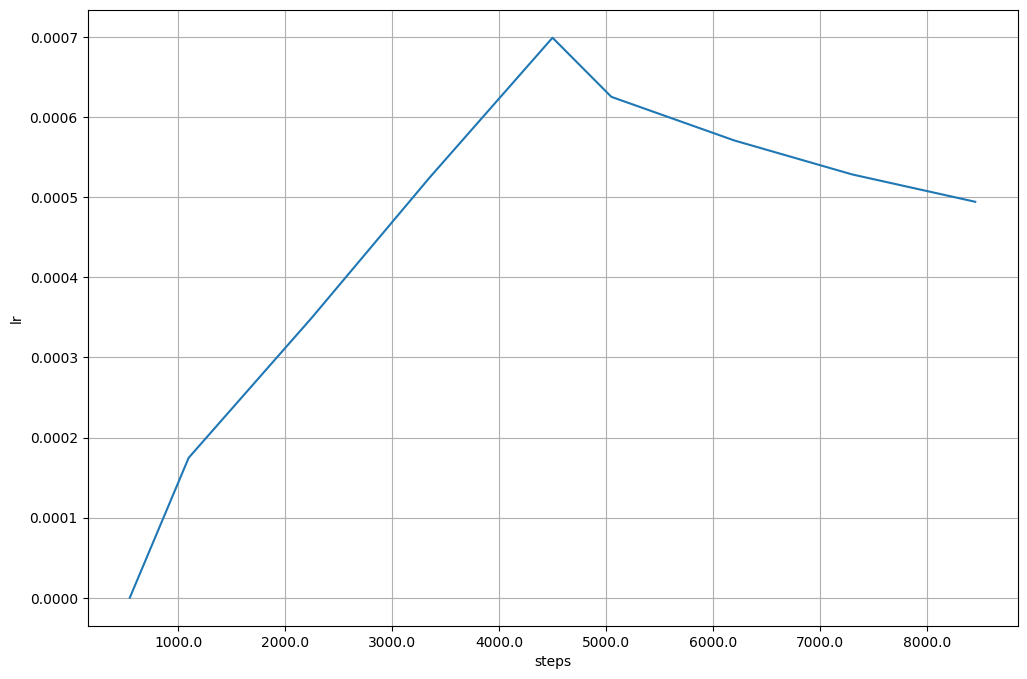

In [35]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(lr_by_steps["step"], lr_by_steps["lr"])
ax.set_xlabel("steps")
ax.set_xticklabels(ax.get_xticks())
ax.set_ylabel("lr")
ax.grid(True)


## Перевод

In [36]:
class Translator:
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        rus_tokenizer: Tokenizer,
        eng_tokenizer: Tokenizer,
        max_translated_len: int,
        device: torch.device,
    ):
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.rus_tokenizer = rus_tokenizer
        self.eng_tokenizer = eng_tokenizer
        self.device = device
        self.max_translated_len = max_translated_len

    @torch.inference_mode
    def greedy_decode(self, sentence: str) -> str:
        input_ids = self.rus_tokenizer.encode(sentence).ids
        input_tensor = torch.tensor([input_ids], device=self.device)

        encoder_outputs = self.encoder(input_tensor)

        start_token_id = self.eng_tokenizer.token_to_id("[BOS]")
        end_token_id = self.eng_tokenizer.token_to_id("[EOS]")

        decoder_input = torch.tensor([[start_token_id]], device=self.device)

        for _ in range(self.max_translated_len):
            seq_len = decoder_input.size(1)
            attention_mask = torch.triu(
                torch.ones((seq_len, seq_len), device=self.device), diagonal=1
            )

            logits = self.decoder(
                decoder_input,
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
            )

            next_token_logits = logits[0, -1, :]
            probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.argmax(probs).item()

            if next_token_id == end_token_id:
                break

            # опционально — anti-repeat эвристика
            if next_token_id in decoder_input[0][-3:]:
                break

            next_token_tensor = torch.tensor(
                [[next_token_id]], device=self.device
            )
            decoder_input = torch.cat(
                [decoder_input, next_token_tensor], dim=1
            )

        output_ids = decoder_input[0].cpu().tolist()
        translated_text = self.eng_tokenizer.decode(output_ids)

        return translated_text

    @torch.inference_mode
    def test_sentences(
        self, rus_sentences: list[str], eng_sentences: list[str]
    ) -> pd.DataFrame:
        temp_dict = {
            "Rus Original": [],
            "Rus Tokenized": [],
            "Eng Original": [],
            "Eng Translation": [],
        }

        for rus_sentence, eng_sentence in tqdm(
            zip(rus_sentences, eng_sentences), desc="Translating"
        ):
            temp_dict["Rus Original"].append(rus_sentence)
            tokenized_rus = self.rus_tokenizer.encode(rus_sentence).tokens
            temp_dict["Rus Tokenized"].append(tokenized_rus)
            temp_dict["Eng Original"].append(eng_sentence)
            translated = self.greedy_decode(rus_sentence)
            temp_dict["Eng Translation"].append(translated)

        return pd.DataFrame(temp_dict)

In [37]:
translator = Translator(
    lit_model.model.encoder,
    lit_model.model.decoder,
    rus_tokenizer,
    eng_tokenizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    max_translated_len=30,
)

In [38]:
df = translator.test_sentences(
    test_rus_sentences[:100], test_eng_sentences[:100]
)

Translating: 100it [00:04, 20.40it/s]


In [39]:
df.head(20)

,Rus Original,Rus Tokenized,Eng Original,Eng Translation
0,Том вчера не был у меня дома.,"[том, вчера, не, был, у, меня, дома, .]",Tom wasn't at my house yesterday.,from my house yesterday . i was at home .
1,Кто-нибудь из твоих друзей рисует?,"[кто, -, нибудь, из, твоих, друзей, рисует, ?]",Do any of your friends paint?,your friends ? what ' s from ? what
2,Поверх пижамы он носил халат.,"[поверх, [UNK], он, носил, [UNK], .]",He wore a robe over his pajamas.,he is a man with
3,Том расстроен.,"[том, расстроен, .]",Tom's upset.,is tom . he ' s . i am upset . he is
4,"Том вёл себя, словно безумец.","[том, вёл, себя, ,, словно, [UNK], .]",Tom acted like a madman.,tom behaved himself . been selfish
5,"Давайте посмотрим, что происходит снаружи.","[давайте, посмотрим, ,, что, происходит, снар...",Let's see what's happening outside.,' s admit what ' s going on the street . outside
6,Он открыл дверцу автомобиля.,"[он, открыл, дверцу, автомобиля, .]",He opened the door of the car.,he opened the car . he ' s a car . he was
7,Том знает почему.,"[том, знает, почему, .]",Tom knows why.,tom knows why .
8,Том готовился.,"[том, готовился, .]",Tom was getting ready.,tom . he ' s in . d be dressed .
9,Он ходит в школу для глухих.,"[он, ходит, в, школу, для, глухих, .]",He goes to a school for the deaf.,he is for school . he ' s a long school . bein...


## Вывод

- Хорошее качество, хоть перевод и кажется плохим. Это нормально для такого маленького тренировочного набора (70 к). Модель переобучается.

**Как улучшить?**
- **Увеличить набор данных**;
- можно добавить `label_smoothing (0.1-0.2)` в `cross entropy`;
- увеличить `dropout`;
- `Beam-Search` на инференсе.